<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install dtw-python

In [ ]:
pip install dtreeviz

In [ ]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LarsCV, Lasso, Ridge, BayesianRidge
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, AdaBoostRegressor, BaggingRegressor
from math import sqrt
from dtw import *
%matplotlib inline

sns.set_theme(style="white")

In [4]:
def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

In [5]:
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; NARA='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-";
def print_serie2(serie_,prototipo_,title_,ytitle_,xtitle_,sizex_=8,sizey_=5,namefile_='figure.png'):
    fig, ax1 = plt.subplots(figsize=(sizex_,sizey_))
    plt.title(title_,fontsize='x-large',color=NARA)
    ax1.set_xlabel(xtitle_, color=NARA, fontsize='large')
    ax1.set_ylabel(ytitle_, color=NARA, fontsize='large')
    plt.tick_params(colors = NARA, which='both')
    ax1.spines['bottom'].set_color(NARA)
    ax1.spines['top'   ].set_color(NARA) 
    ax1.spines['right' ].set_color(NARA)
    ax1.spines['left'  ].set_color(NARA)
    if len(prototipo_) != 0: 
        plt.plot(prototipo_,alpha=0.6, linestyle='dashed', color='red', linewidth=3)
    for p in serie_:
        plt.plot(p,alpha=0.3, linewidth=2)    
    plt.savefig(namefile_, transparent=True)         
    plt.show()

In [6]:
## Preparamos la información para graficar la importancia y las posiciones en Random Forest Regressor
def print_importances(model_,labels_,namefile_):
    i=0
    labels = [str(x) for x in labels_]
    labels_importances = []
    for feature in model_.feature_importances_:
        labels_importances.append((feature,labels[i]))
        i=i+1   
    labels_importances.sort(key=lambda tup: tup[0], reverse=False)
    importances = []
    labels      = []
    for tup in labels_importances:
        importances.append(tup[0])
        labels.append(tup[1])
    fig, ax = plt.subplots()
    y_pos = np.arange(len(importances))
    ax.set_yticks(ticks=y_pos)
    ax.barh(labels, importances, align='center',color=CYAN)
    ax.invert_yaxis()
    ax.set_xlabel('Importancia', color=NARA, fontsize='large')
    ax.set_ylabel('Variable', color=NARA, fontsize='large')
    ax.set_title( 'Importancia de las variables del bosque aleatorio', color=NARA, fontsize='large')    
    plt.tick_params(colors = NARA, which='both')
    ax.spines['bottom'].set_color(NARA)
    ax.spines['top'   ].set_color(NARA) 
    ax.spines['right' ].set_color(NARA)
    ax.spines['left'  ].set_color(NARA)
    plt.savefig(namefile_, transparent=True)   
    plt.show()

In [7]:
def OLS(X, Y, X_2, pi_step_=0.001,verbose_=False):
    model   = sm.OLS(Y, X)
    results = model.fit()
    prediction_Y2 = results.predict(X_2)

    ## Ordenamos los valores 'pi' y se selecciona el más grande.
    i = 0
    pvalues = []
    for pi in results.pvalues:
        pvalues.append((i,pi))
        i = i + 1
    pvalues.sort(key=lambda tup: tup[1], reverse=True) ## Ordenamos por 'pi'
    (i, pi) = pvalues[0]  

    while pi > pi:
        X   = sm.add_constant(X)
        X_2 = sm.add_constant(X_2)   
        if verbose_==True:
            print('Retiramos regresor ---> X' + str(i))
        X   = np.delete(arr=X,   obj=i+0, axis=1)
        X_2 = np.delete(arr=X_2, obj=i+0, axis=1)   
        model   = sm.OLS(Y, X)
        results = model.fit()

        ## Ordenamos los valores 'pi' y se selecciona el más grande
        i = 0
        pvalues = []
        for pi in results.pvalues:
            pvalues.append((i,pi))
            i = i + 1
        pvalues.sort(key=lambda tup: tup[1], reverse=True) ## Ordenamos por 'pi'
        (i, pi) = pvalues[0]
        #prediction   = results.predict(X)   ## Ajuste
        prediction_Y2 = results.predict(X_2) ## Pronóstico
    if len(prediction_Y2) == 0:      
        if verbose_==True:
            print('>>> Warning, no variable was significant in the regression.')
        model   = sm.OLS(Y, X)
        results = model.fit()
        prediction_Y2 = results.predict(X_2)
        
    if verbose_==True:
        print(results.summary())
    return prediction_Y2   

In [8]:
def RF(X, Y, X_2,labels_,typedist_,verbose_=False):
    model         = RandomForestRegressor(random_state=42,) ## RF default
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)

    if verbose_==True:
        print_importances(model_=model,labels_=labels_,namefile_='fig_importance_'+typedist_+'_'+'RF')
        print('Parámetros utilizados RF')
        print("bootstrap:         {}".format(model.bootstrap))
        print("n_estimators:      {}".format(model.n_estimators))
        print("max_features:      {}".format(model.max_features))
        print("max_depth:         {}".format(model.max_depth))
        print("min_samples_leaf:  {}".format(model.min_samples_leaf))
        print("min_samples_split: {}".format(model.min_samples_split))
    return prediction_Y2   

In [9]:
def AutoRF(X, Y, X_2,labels_,typedist_,verbose_=False):
## https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
    #nestlist = []
    #for i in range(10, 320, 50):
    #    nestlist.append(i)
    #param_grid = { 
    #'bootstrap': [True, False],
    #'n_estimators': nestlist,
    #'max_features': ['auto', 'sqrt', 'log2'],
    #'max_depth' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    #'min_samples_leaf': [1, 2, 4],
    #'min_samples_split': [2, 5, 10],}

    nestlist = []
    for i in range(10, 320, 50):
        nestlist.append(i)
    param_grid = { 
    'bootstrap': [True, False],
    'n_estimators': nestlist,
    'max_features': ['auto', 'sqrt',],
    'max_depth' : [10, 20, None]}

    model = RandomForestRegressor(random_state=42)
    clf   = GridSearchCV(estimator=model, param_grid=param_grid, cv=5).fit(X, Y)
    model         = clf.best_estimator_
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)

    if verbose_==True:
        print_importances(model_=model,labels_=labels_,namefile_='fig_importance_'+typedist_+'_'+'AutoRF')
        print('Parameters used')
        print("bootstrap:         {}".format(model.bootstrap))
        print("n_estimators:      {}".format(model.n_estimators))
        print("max_features:      {}".format(model.max_features))
        print("max_depth:         {}".format(model.max_depth))
        print("min_samples_leaf:  {}".format(model.min_samples_leaf))
        print("min_samples_split: {}".format(model.min_samples_split))
        
    return prediction_Y2   

In [10]:
def Voting(X, Y, X_2,verbose_=False):  
    ## https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_regressor.html#sphx-glr-auto-examples-ensemble-plot-voting-regressor-py
    gb = GradientBoostingRegressor(random_state=42)
    rf = RandomForestRegressor(random_state=42)
    br = BaggingRegressor(random_state=42)
    lr = LinearRegression()
    ab = AdaBoostRegressor(random_state=42)
    by = BayesianRidge(compute_score=True)
    ls = Lasso()
    gb.fit(X, Y)
    rf.fit(X, Y)
    br.fit(X, Y)
    lr.fit(X, Y)
    ab.fit(X, Y)
    by.fit(X, Y)
    ls.fit(X, Y)
    voting = VotingRegressor([("gb", gb), ("rf", rf), ("br", br), ("lr", lr), ("ab", ab), ("by", by), ("ls", ls)]) # 
    voting.fit(X, Y)
    prediction_Y2 = voting.predict(X_2)    
    if verbose_ == True:
        predgb = gb.predict(X_2)
        predrf = rf.predict(X_2)
        predbr = br.predict(X_2)
        predlr = lr.predict(X_2)      
        predab = ab.predict(X_2)       
        predby = by.predict(X_2)       
        predls = ls.predict(X_2)
        plt.figure() 
        ## Markers, Line styles ,Colors
        ## https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.plot.html 
        plt.plot(predgb,  "gd", label="GradientBoostingRegressor") ## go- rs 
        plt.plot(predrf,  "b^", label="RandomForestRegressor")
        plt.plot(predbr,  "go-",label="BaggingRegressor")
        plt.plot(predlr,  "ys", label="LinearRegression")
        plt.plot(predab,  "bo", label="AdaBoostRegressor")
        plt.plot(predby,  "bo", label="Lasso")
        plt.plot(predls,  "ys-", label="")
        plt.plot(prediction_Y2, "r*", ms=10, label="VotingRegressor")

        plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
        plt.ylabel("predicted")
        plt.xlabel("training samples")
        plt.legend(loc="best")
        plt.title("Regressor predictions and their average")
        plt.show()
    return prediction_Y2   

In [11]:
#https://drive.google.com/drive/folders/1Gj3XK9kM-lE18uBMe3qrZOGEm8yAI8i9
#https://www.codegrepper.com/code-examples/python/how+to+read+csv+file+from+google+drive+on+google+colab+
path        = 'https://drive.google.com/uc?export=download&id=' 
URL_Demanda = 'https://drive.google.com/file/d/1xcpXDTE7H6EBMLOkic5lq-lzSwiLG2ZS/view?usp=sharing'

df_Demanda  = pd.read_csv(path + URL_Demanda .split('/')[-2], usecols=[0] ) #names=['CLVUNI','TYPE','NODE'], usecols=[1,2,3,4,5,6,], 1,2,3,4,5,6,7,8,9,10,11,12,13,15,
df_Demanda.dropna(inplace=True)
serie = df_Demanda.to_numpy()
serie = StandardScaler().fit_transform(serie)
serie = serie.ravel() ## Con esto quitamos el bracket o corchete en cada uno de los elementos del arreglo

In [12]:
## Calcula distancia euclidiana
def euclidean(neig1, neig2):
	  distance = 0.0
	  for i in range(len(neig1)):
		    distance += (neig1[i] - neig2[i])**2
	  return sqrt(distance)

In [13]:
def analogo_knn(serie,vsele,k=10,tol=0.8,typedist='euclidian',typereg='OLS',verbose=False):    
#    vsel       : Tamanio de la ventana de selección
#    vfor       : Tamanio de la ventana de pronóstico
#    k          : Número de vecinos a buscar k
#    tol        : Tolerancia de tamaño de ventanas para seleccion de vecinos
#    typedist   : medida de distancia, 'dtw' o 'euclidian' o 'pearson'

    t_o = time.time()
    n = len(serie) ## longitud total de la serie

    ## PASO 1: Selección de las ventanas de mayor correlación.

    ## Calculamos la distancia entre todos los vecinos.
    vsele = vsele
    distances = []
    Y = serie[n-vsele:n]           ## últimos datos
    for i in range(n-2*vsele):                              
        if  typedist == 'dtw':     ## dynamic time warping
            dist = dtw(Y, serie[i:i+vsele]).distance  
        elif typedist == 'pearson':
            dist = np.corrcoef(Y,serie[i:i+vsele])[1,0]
        else:
            dist = euclidean(Y,serie[i:i+vsele])
        if dist > 0:
            distances.append((i, dist))
        
    ## Calculamos el vecindario por distancia de menor a mayor y se guardan las posiciones.
    if typedist == 'pearson':
        ## En caso de pearson se ordena al revés, nos interesan los mayor correlación.
        distances.sort(key=lambda tup: tup[1], reverse=True)
    else:
        ## En caso de pearson se ordena al revés, nos interesan los de menor distancia.
        distances.sort(key=lambda tup: tup[1], reverse=False)

    neighbors  = []
    neighbors2 = []
    positions  = []

    ## Calculamos los k vecinos mas cercanos y guardamos las posiciones.
    i = 0
    for pos, dis in distances:
        if i==0:      
            positions.append(pos)   
            neighbors.append(serie[pos:pos+vsele])
            neighbors2.append(serie[pos+vsele:pos+2*vsele])  
        else:
            bandera = True
            for p in positions:
                 ## si ya teniamos una posición en la lista que pase la tolerancia, ya no la guardamos 
                if (abs(pos - p) < tol*vsele):
                    bandera = False
                    i = i - 1
                    break
            if bandera == True:
                ## Guarda nuevo vecino
                positions.append(pos)   
                neighbors.append(serie[pos:pos+vsele])
                neighbors2.append(serie[pos+vsele:pos+2*vsele])  
                bandera = False
        i = i + 1
        if i == k:
            break
    if verbose==True:
        print('positions KNN:', positions) ## posición de los k vecinos mas cercanos

    neighbors  = np.array(neighbors)  
    neighbors2 = np.array(neighbors2)    
    vacia = []
    if verbose==True:
        print_serie2(neighbors,Y,'Selección con KNN:'+typedist,'demanda','time',8,5,'fig_t16_X_'+typedist+'_'+typereg)

    t_sel = time.time() - t_o

    ## PASO 2: Regresión entre los vecinos mas cercanos 'X' y la última ventana 'Y'

    ## Definimos nuestros regresores   
    X   = (neighbors.T).tolist()
    X_2 = (neighbors2.T).tolist()
    Y   = (Y).tolist()
    prediction_Y2 = []

    ## -- Random forest regression --
    if typereg == 'RF':
        prediction_Y2 = RF(X,Y,X_2,labels_=positions,typedist_=typedist,verbose_=verbose)

    ## -- OLS with Stepwise --
    if typereg == 'OLS':
        prediction_Y2 = OLS(X,Y,X_2, pi_step_=0.001,verbose_=verbose)

    ## -- Voting regression -- 
    if typereg == 'Voting':
        prediction_Y2 = Voting(X,Y,X_2,verbose_=verbose)

    ## -- Random forrest regression with GridSearchCV--
    if typereg == 'AutoRF':
        prediction_Y2 = AutoRF(X, Y, X_2,labels_=positions,typedist_=typedist,verbose_=verbose)
        
            
    if verbose==True:
        print_serie2(neighbors2,prediction_Y2, 'Pronóstico - ' + typedist+' - ' + typereg ,'Demanda','Tiempo',8,5,'fig_t15_Y2_'+typedist+'_'+typereg)

    t_reg = time.time() - t_sel - t_o

    return prediction_Y2, t_sel, t_reg

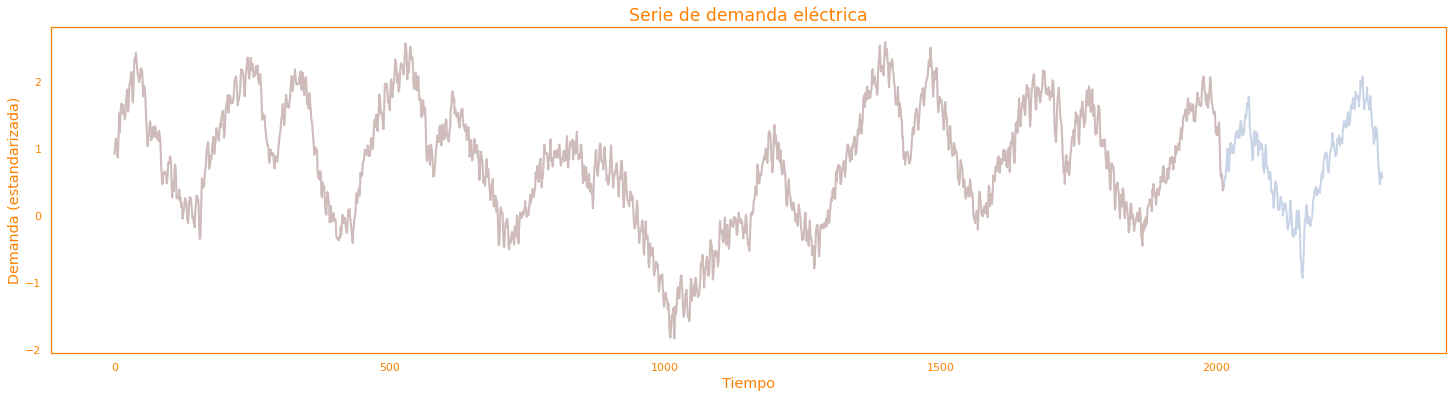

In [14]:
## ... (time serie) ... window.window.window.window.window.window.window.window.window.window.window.
##                                           |                                               |       |
##                                           |                                               |       |
##                                           |<------------------ vsele -------------------->|<vpred>|
##                                                       (selection and regression)        (prediction)
##                                                                                                 
##|<---------------------------------------- train ----------------------------------------->|<test>|

## Parámetros de método Análogo
periods       = 288        ## Número de periodos en una ventana
periods_sele  = 7          ## Número de ventanas de selección
periods_pred  = 1          ## Número de ventanas de pronóstico

vsele = periods * periods_sele ## Número de periodos para selección
vpred = periods * periods_pred ## Número de periodos para pronóstico

k   = 6   ## k:   número de vecinos mas cercanos
tol = 0.8 ## tol: porcentaje de tolerancia de cercania entre ventanas

## Dibujamos la ventana de histórico y los datos de prueba  
series = []; vacia = []; n = 2
series.append(serie[len(serie)-n*vsele : len(serie)-vsele+vpred])
series.append(serie[len(serie)-n*vsele : len(serie)-vsele])
print_serie2(serie_=series,prototipo_=vacia , title_='Serie de demanda eléctrica', ytitle_='Demanda (estandarizada)',xtitle_='Tiempo', sizex_=25, sizey_=6, namefile_='fig_t15_demanda')

## Definimos la ventana de prueba y entrenamiento
X_train = serie[0 : len(serie) - vpred]
y_test  = serie[len(serie) - vpred : len(serie)]

---
## Probamos el modelo con 'pearson' + 'RF'.

In [15]:
if 1==1:
    pred_pea_rf, t_sel_pea_rf, t_reg_pea_rf = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,typedist='pearson',typereg='RF',verbose=False)
    mae_pea_rf  = mean_absolute_error(y_test,pred_pea_rf[0:vpred])
    mape_pea_rf = mean_absolute_percentage_error(y_test,pred_pea_rf[0:vpred])

---
## Probamos el modelo con 'pearson' + 'OLS'.

In [16]:
if 1==1:
    pred_pea_ols, t_sel_pea_ols, t_reg_pea_ols = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,typedist='pearson',typereg='OLS',verbose=False)
    mae_pea_ols  = mean_absolute_error(y_test,pred_pea_ols[0:vpred])    
    mape_pea_ols = mean_absolute_percentage_error(y_test,pred_pea_ols[0:vpred])

---
## Probamos el modelo con 'pearson' + 'Voting'.

In [17]:
if 1==1:
    pred_pea_vot, t_sel_pea_vot, t_reg_pea_vot = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,typedist='pearson',typereg='Voting',verbose=False)
    mae_pea_vot = mean_absolute_error(y_test,pred_pea_vot[0:vpred])
    mape_pea_vot = mean_absolute_percentage_error(y_test,pred_pea_vot[0:vpred])

---
## Probamos el modelo con 'euclidian' + 'RF'.

In [18]:
if 1==1:
    pred_euc_rf, t_sel_euc_rf, t_reg_euc_rf = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,typedist='euclidian',typereg='RF',verbose=False)
    mae_euc_rf  = mean_absolute_error(y_test,pred_euc_rf[0:vpred])
    mape_euc_rf = mean_absolute_percentage_error(y_test,pred_euc_rf[0:vpred])

---
## Probamos el modelo con 'euclidian' + 'OLS' 

In [19]:
if 1==1:
    pred_euc_ols, t_sel_euc_ols, t_reg_euc_ols = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,typedist='euclidian',typereg='OLS',verbose=False)
    mae_euc_ols  = mean_absolute_error(y_test,pred_euc_ols[0:vpred])
    mape_euc_ols = mean_absolute_percentage_error(y_test,pred_euc_ols[0:vpred])

---
## Probamos el modelo con 'euclidian' + 'Voting'.

In [20]:
if 1==1:
    pred_euc_vot, t_sel_euc_vot, t_reg_euc_vot = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,typedist='euclidian',typereg='Voting',verbose=False)
    mae_euc_vot  = mean_absolute_error(y_test,pred_euc_vot[0:vpred])
    mape_euc_vot = mean_absolute_percentage_error(y_test,pred_euc_vot[0:vpred])

---

## Probamos el modelo con 'euclidian' + 'AutoRF'.

In [21]:
if 1==1:
    pred_euc_arf, t_sel_euc_arf, t_reg_euc_arf = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,typedist='euclidian',typereg='AutoRF',verbose=False)
    mae_euc_arf  = mean_absolute_error(y_test,pred_euc_arf[0:vpred])
    mape_euc_arf = mean_absolute_percentage_error(y_test,pred_euc_arf[0:vpred])

---

## Probamos el modelo con 'pearson' + 'AutoRF'.



In [22]:
if 1==1:
    pred_pea_arf, t_sel_pea_arf, t_reg_pea_arf = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,typedist='pearson',typereg='AutoRF',verbose=False)
    mae_pea_arf  = mean_absolute_error(y_test,pred_pea_arf[0:vpred])
    mape_pea_arf = mean_absolute_percentage_error(y_test,pred_pea_arf[0:vpred])

---
## Probamos el modelo con 'dtw' + 'OLS'.

In [23]:
if 1==0:
    pred_dtw_ols, t_sel_dtw_ols, t_reg_dtw_ols = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,typedist='dtw',typereg='OLS',verbose=False)
    mae_dtw_ols  = mean_absolute_error(y_test,pred_dtw_ols[0:vpred])
    mape_dtw_ols = mean_absolute_percentage_error(y_test,pred_dtw_ols[0:vpred])

---
## Probamos el modelo con 'dtw' + 'RF'.

In [24]:
if 1==0:
    pred_dtw_rf, t_sel_dtw_rf, t_reg_dtw_rf = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,typedist='dtw',typereg='RF',verbose=False)
    mae_dtw_rf  = mean_absolute_error(y_test,pred_dtw_rf[0:vpred])
    mape_dtw_rf = mean_absolute_percentage_error(y_test,pred_dtw_rf[0:vpred])

---
## Comparamos graficamente los resultados

In [28]:
print('| SELECCIÓN      | REGRESIÓN      | MAE             | MAPE             | TIEMPO SELECCIÓN     | TIEMPO REGRESIÓN  |')
print('| :------------- | :------------- | -------------:  | -------------:   |-------------:        |-------------:     |')
print('| PEARSON        | RF             |',str(trunc(mae_pea_rf,4)),'         |',str(trunc(mape_pea_rf,4)),'         |',str(trunc(t_sel_pea_rf,4)),'              |   ',str(trunc(t_reg_pea_rf,4)),     '        |')
print('| EUCLIDIAN      | RF             |',str(trunc(mae_euc_rf,4)),'         |',str(trunc(mape_euc_rf,4)),'         |',str(trunc(t_sel_euc_rf,4)),'             |   ',str(trunc(t_reg_euc_rf,4)),     '        |')
print('| PEARSON        | OLS + STEP     |',str(trunc(mae_pea_ols,4)),'         |',str(trunc(mape_pea_ols,4)),'         |',str(trunc(t_sel_pea_ols,4)),'              |   ',str(trunc(t_reg_pea_ols,4)), '        |')
print('| EUCLIDIAN      | OLS + STEP     |',str(trunc(mae_euc_ols,4)),'         |',str(trunc(mape_euc_ols,4)),'         |',str(trunc(t_sel_euc_ols,4)),'             |   ',str(trunc(t_reg_euc_ols,4)),  '        |')
print('| PEARSON        | Voting         |',str(trunc(mae_pea_vot,4)),'         |',str(trunc(mape_pea_vot,4)),'         |',str(trunc(t_sel_pea_vot,4)),'              |   ',str(trunc(t_reg_pea_vot,4)), '        |')
print('| EUCLIDIAN      | Voting         |',str(trunc(mae_euc_vot,4)),'         |',str(trunc(mape_euc_vot,4)),'          |',str(trunc(t_sel_euc_vot,4)),'             |   ',str(trunc(t_reg_euc_vot,4)), '        |')
print('| PEARSON        | AutoRF         |',str(trunc(mae_pea_arf,4)),'         |',str(trunc(mape_pea_arf,4)),'         |',str(trunc(t_sel_pea_arf,4)),'              |   ',str(trunc(t_reg_pea_arf,4)), '      |')
print('| EUCLIDIAN      | AutoRF         |',str(trunc(mae_euc_arf,4)),'         |',str(trunc(mape_euc_arf,4)),'         |',str(trunc(t_sel_euc_arf,4)),'             |   ',str(trunc(t_reg_euc_arf,4)),  '      |')

#print('| DTW            | OLS + STEP     |',str(trunc(mae_dtw_ols,4)),'         |',str(trunc(mape_dtw_ols,4)),'         |',str(trunc(t_sel_dtw_ols,4)),'            |   ',str(trunc(t_reg_dtw_ols,4)),    '|')
#print('| DTW            | RF             |',str(trunc(mae_dtw_rf,4)),'         |',str(trunc(mape_dtw_rf,4)),'          |',str(trunc(t_sel_dtw_rf,4)),'            |   ',str(trunc(t_reg_dtw_rf,4)),    '|')

| SELECCIÓN      | REGRESIÓN      | MAE             | MAPE             | TIEMPO SELECCIÓN     | TIEMPO REGRESIÓN  |
| :------------- | :------------- | -------------:  | -------------:   |-------------:        |-------------:     |
| PEARSON        | RF             | 0.4576          | 21.4238          | 2.7347               |    0.9906         |
| EUCLIDIAN      | RF             | 0.4539          | 21.7763          | 59.1267              |    0.9558         |
| PEARSON        | OLS + STEP     | 0.2346          | 36.1821          | 3.0768               |    0.0098         |
| EUCLIDIAN      | OLS + STEP     | 0.2403          | 33.5331          | 26.8511              |    0.01         |
| PEARSON        | Voting         | 0.2957          | 16.7334          | 3.0805               |    5.4024         |
| EUCLIDIAN      | Voting         | 0.2787          | 21.699           | 26.0656              |    4.5059         |
| PEARSON        | AutoRF         | 0.4236          | 18.5637          | 2

No handles with labels found to put in legend.


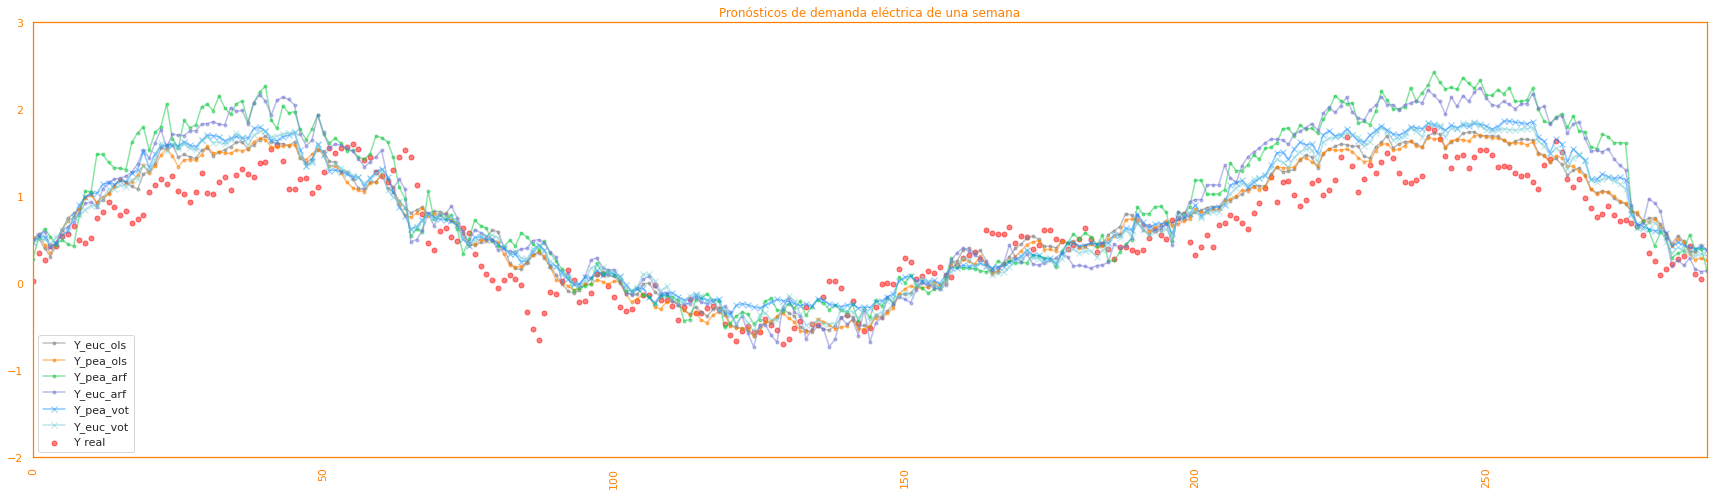

In [26]:
fig  = plt.figure(figsize=(30,8))
axes = fig.add_subplot(1, 1, 1)
axes.legend()
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; NARA ='#ff8000'; AZUL='#168fff'; GRIS = '#808080'
mytitle = plt.title('Pronósticos de demanda eléctrica de una semana') # get the title property handler #plt.getp(title_obj)
plt.setp(mytitle,    color=LETRASNARA) #set the color of title to red
axes.xaxis.label.set_color(LETRASNARA)
axes.yaxis.label.set_color(LETRASNARA)
axes.tick_params(colors=LETRASNARA, which='both')

AUX = np.arange( len(y_test) )
plt.scatter ( AUX, y_test, s=25,marker='o', color = 'red', label = 'Y real', alpha=1/2)
#axes.plot   ( y_test ,     '.-', color = 'red', label = 'Y',         alpha=1/4)
axes.plot   ( pred_euc_ols, '.-', color = GRIS , label = 'Y_euc_ols', alpha=1/2)
axes.plot   ( pred_pea_ols, '.-', color = NARA , label = 'Y_pea_ols', alpha=1/2)
#axes.plot  ( pred_dtw_ols, '.-', color = LILA , label = 'Y_dtw_ols', alpha=1/2)
#axes.plot  ( pred_euc_rf,  '.-', color = NARA , marker='x', label = 'Y_euc_rf', alpha=1/2)
#axes.plot  ( pred_pea_rf,  '.-', color = GRIS , marker='x', label = 'Y_pea_rf' , alpha=1/2)
axes.plot   ( pred_pea_arf, '.-', color = VERDE, label = 'Y_pea_arf' , alpha=1/2)
axes.plot   ( pred_euc_arf, '.-', color = LILA , label = 'Y_euc_arf' , alpha=1/2)
#axes.plot  ( pred_dtw_rf,  '.-', color = AZUL , label = 'Y_dtw_rf', alpha=1/2)
#axes.plot  ( pred_pea_arf, '.-', color = AZUL , label = 'Y_pea_arf' , alpha=1/2)
axes.plot   ( pred_pea_vot, '.-', color = AZUL , marker='x', label = 'Y_pea_vot', alpha=1/2)
axes.plot   ( pred_euc_vot, '.-', color = CYAN , marker='x', label = 'Y_euc_vot', alpha=1/2)
#axes.plot  ( xspline[3], yspline[3] , '.-'  , color = VERDE   , label = 'orden=4'  ,alpha=1/2)
#plt.scatter( dfx_miss, dfy_miss, marker='x',  s=170 ,  color = 'red' , label = 'perdidos' ,alpha=1)
marker='x',
plt.axis([0,  288, -2, 3])

axes.spines['bottom'].set_color(LETRASNARA)
axes.spines['top'   ].set_color(LETRASNARA) 
axes.spines['right' ].set_color(LETRASNARA)
axes.spines['left'  ].set_color(LETRASNARA)
plt.legend()  
plt.xticks(rotation=90)
plt.savefig('fig_t15_ajuste_prono.png', transparent=True)
plt.show()

### Ligas interesantes

[sklearn.ensemble: Ensemble Methods](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble)

[Ensemble methods sklearn](https://scikit-learn.org/0.16/modules/ensemble.html)

[Growing and Pruning Ensembles in Python](https://machinelearningmastery.com/growing-and-pruning-ensembles-in-python/)

[sklearn.feature_selection.RFE](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE)

[link texHow to Develop a Random Forest Ensemble in Python](https://machinelearningmastery.com/random-forest-ensemble-in-python/)